In [2]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    print(mean_image.shape)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

(32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


Training
Iteration 0: with minibatch training loss = 11.6 and accuracy of 0.078
Iteration 100: with minibatch training loss = 1.63 and accuracy of 0.41
Iteration 200: with minibatch training loss = 1.48 and accuracy of 0.42
Iteration 300: with minibatch training loss = 1.4 and accuracy of 0.45
Iteration 400: with minibatch training loss = 1.55 and accuracy of 0.38
Iteration 500: with minibatch training loss = 1.12 and accuracy of 0.56
Iteration 600: with minibatch training loss = 1.05 and accuracy of 0.56
Iteration 700: with minibatch training loss = 1.31 and accuracy of 0.61
Epoch 1, Overall loss = 1.49 and accuracy of 0.47


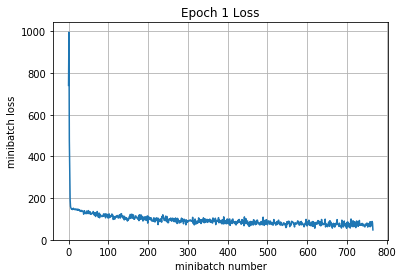

Validation
Epoch 1, Overall loss = 1.17 and accuracy of 0.577


In [5]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [4]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    
    #con-relu-batchnorm-conv-relu-batchnorm-pool 
    conv1 = tf.layers.conv2d(
        inputs=X,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm1 = tf.layers.batch_normalization(inputs=conv1,axis=3)
    print(batchnorm1.shape)
    
    conv2 = tf.layers.conv2d(
        inputs=batchnorm1,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm2 = tf.layers.batch_normalization(inputs=conv2,axis=3)
    
    pool1 = tf.layers.max_pooling2d(inputs=batchnorm2,pool_size=[2,2],strides=2)
    
    
    
    
   #con-relu-batchnorm-conv-relu-batchnorm-pool 
    conv3 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm3 = tf.layers.batch_normalization(inputs=conv3,axis=3)
    
    
    conv4 = tf.layers.conv2d(
        inputs=batchnorm3,
        filters=64,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm4 = tf.layers.batch_normalization(inputs=conv4,axis=3)
    
    pool2 = tf.layers.max_pooling2d(inputs=batchnorm4,pool_size=[2,2],strides=2)
    
     
    #con-relu-batchnorm-conv-relu-batchnorm-pool 
    
    conv5 = tf.layers.conv2d(
        inputs=pool2,
        filters=128,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm5 = tf.layers.batch_normalization(inputs=conv5,axis=3)
    
    
    conv6 = tf.layers.conv2d(
        inputs=batchnorm5,
        filters=128,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm6 = tf.layers.batch_normalization(inputs=conv6,axis=3)

    pool3 = tf.layers.max_pooling2d(inputs=batchnorm6,pool_size=[2,2],strides=2)
    
    
    #dense layer
    pool3_flat = tf.reshape(pool3,[-1,2048])
    dense1 = tf.layers.dense(inputs=pool3_flat,units=1024,activation=tf.nn.relu)
    
    batchnorm7 = tf.layers.batch_normalization(inputs=dense1,axis=1)
    print(batchnorm7.shape)
    

    dropout1 = tf.layers.dropout(inputs=batchnorm7,rate=0.5,training= is_training is not None)
    
    #logits
    logits = tf.layers.dense(inputs=dropout1,units=10)
    
    return logits

    
    pass

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = None
optimizer = None

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),y_out)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.AdamOptimizer(1e-3)


pass

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

(?, 32, 32, 32)
(?, 1024)


Training
Iteration 0: with minibatch training loss = 7.33 and accuracy of 0.14
Iteration 100: with minibatch training loss = 1.79 and accuracy of 0.38
Iteration 200: with minibatch training loss = 1.45 and accuracy of 0.55
Iteration 300: with minibatch training loss = 1.35 and accuracy of 0.55
Iteration 400: with minibatch training loss = 1.23 and accuracy of 0.52
Iteration 500: with minibatch training loss = 1.26 and accuracy of 0.61
Iteration 600: with minibatch training loss = 0.976 and accuracy of 0.69
Iteration 700: with minibatch training loss = 1.62 and accuracy of 0.44
Epoch 1, Overall loss = 1.52 and accuracy of 0.459


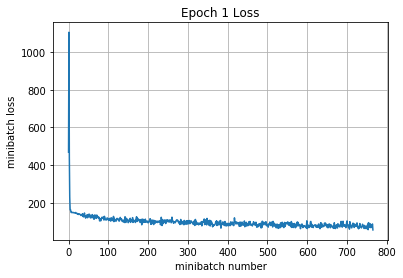

Iteration 800: with minibatch training loss = 1.11 and accuracy of 0.62
Iteration 900: with minibatch training loss = 1.01 and accuracy of 0.62
Iteration 1000: with minibatch training loss = 1.17 and accuracy of 0.62
Iteration 1100: with minibatch training loss = 1.03 and accuracy of 0.61
Iteration 1200: with minibatch training loss = 1.11 and accuracy of 0.53
Iteration 1300: with minibatch training loss = 1.09 and accuracy of 0.58
Iteration 1400: with minibatch training loss = 1.12 and accuracy of 0.64
Iteration 1500: with minibatch training loss = 0.923 and accuracy of 0.69
Epoch 2, Overall loss = 1.03 and accuracy of 0.634


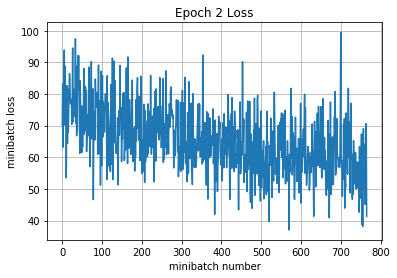

Iteration 1600: with minibatch training loss = 0.853 and accuracy of 0.7
Iteration 1700: with minibatch training loss = 0.91 and accuracy of 0.72
Iteration 1800: with minibatch training loss = 0.762 and accuracy of 0.7
Iteration 1900: with minibatch training loss = 0.794 and accuracy of 0.72
Iteration 2000: with minibatch training loss = 0.727 and accuracy of 0.81
Iteration 2100: with minibatch training loss = 0.656 and accuracy of 0.8
Iteration 2200: with minibatch training loss = 0.892 and accuracy of 0.66
Epoch 3, Overall loss = 0.837 and accuracy of 0.705


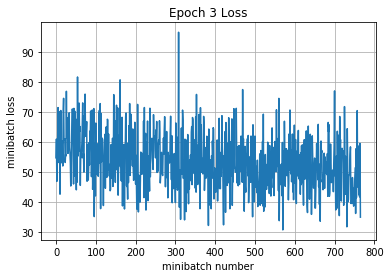

Iteration 2300: with minibatch training loss = 0.572 and accuracy of 0.75
Iteration 2400: with minibatch training loss = 0.737 and accuracy of 0.72
Iteration 2500: with minibatch training loss = 0.722 and accuracy of 0.77
Iteration 2600: with minibatch training loss = 0.817 and accuracy of 0.75
Iteration 2700: with minibatch training loss = 0.663 and accuracy of 0.72
Iteration 2800: with minibatch training loss = 0.956 and accuracy of 0.69
Iteration 2900: with minibatch training loss = 0.65 and accuracy of 0.8
Iteration 3000: with minibatch training loss = 0.669 and accuracy of 0.75
Epoch 4, Overall loss = 0.716 and accuracy of 0.746


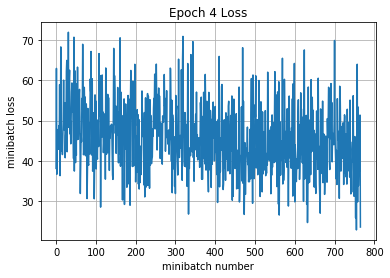

Iteration 3100: with minibatch training loss = 0.671 and accuracy of 0.78
Iteration 3200: with minibatch training loss = 0.593 and accuracy of 0.77
Iteration 3300: with minibatch training loss = 0.745 and accuracy of 0.7
Iteration 3400: with minibatch training loss = 0.557 and accuracy of 0.83
Iteration 3500: with minibatch training loss = 0.603 and accuracy of 0.8
Iteration 3600: with minibatch training loss = 0.615 and accuracy of 0.78
Iteration 3700: with minibatch training loss = 0.69 and accuracy of 0.77
Iteration 3800: with minibatch training loss = 0.597 and accuracy of 0.81
Epoch 5, Overall loss = 0.629 and accuracy of 0.78


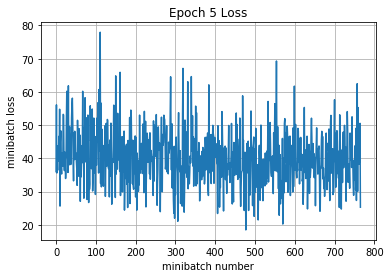

Iteration 3900: with minibatch training loss = 0.51 and accuracy of 0.83
Iteration 4000: with minibatch training loss = 0.484 and accuracy of 0.8
Iteration 4100: with minibatch training loss = 0.668 and accuracy of 0.83
Iteration 4200: with minibatch training loss = 0.324 and accuracy of 0.92
Iteration 4300: with minibatch training loss = 0.585 and accuracy of 0.8
Iteration 4400: with minibatch training loss = 0.288 and accuracy of 0.88
Iteration 4500: with minibatch training loss = 0.48 and accuracy of 0.83
Epoch 6, Overall loss = 0.555 and accuracy of 0.807


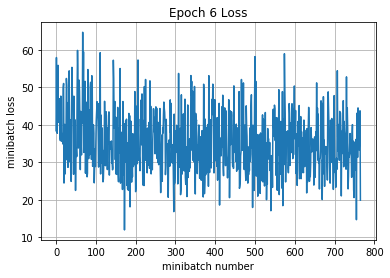

Iteration 4600: with minibatch training loss = 0.644 and accuracy of 0.75
Iteration 4700: with minibatch training loss = 0.861 and accuracy of 0.77
Iteration 4800: with minibatch training loss = 0.401 and accuracy of 0.81
Iteration 4900: with minibatch training loss = 0.449 and accuracy of 0.83
Iteration 5000: with minibatch training loss = 0.499 and accuracy of 0.8
Iteration 5100: with minibatch training loss = 0.366 and accuracy of 0.89
Iteration 5200: with minibatch training loss = 0.418 and accuracy of 0.83
Iteration 5300: with minibatch training loss = 0.346 and accuracy of 0.83
Epoch 7, Overall loss = 0.49 and accuracy of 0.824


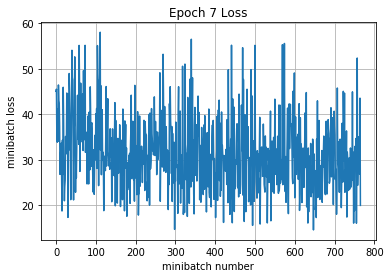

Iteration 5400: with minibatch training loss = 0.301 and accuracy of 0.89
Iteration 5500: with minibatch training loss = 0.445 and accuracy of 0.86
Iteration 5600: with minibatch training loss = 0.614 and accuracy of 0.78
Iteration 5700: with minibatch training loss = 0.302 and accuracy of 0.86
Iteration 5800: with minibatch training loss = 0.261 and accuracy of 0.86
Iteration 5900: with minibatch training loss = 0.406 and accuracy of 0.83
Iteration 6000: with minibatch training loss = 0.688 and accuracy of 0.8
Iteration 6100: with minibatch training loss = 0.299 and accuracy of 0.91
Epoch 8, Overall loss = 0.424 and accuracy of 0.853


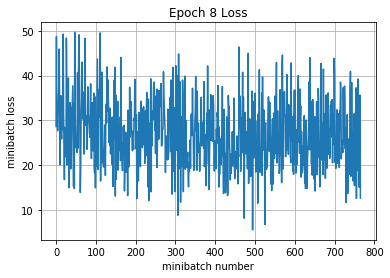

Iteration 6200: with minibatch training loss = 0.556 and accuracy of 0.81
Iteration 6300: with minibatch training loss = 0.152 and accuracy of 0.94
Iteration 6400: with minibatch training loss = 0.524 and accuracy of 0.77
Iteration 6500: with minibatch training loss = 0.448 and accuracy of 0.77
Iteration 6600: with minibatch training loss = 0.419 and accuracy of 0.84
Iteration 6700: with minibatch training loss = 0.272 and accuracy of 0.91
Iteration 6800: with minibatch training loss = 0.459 and accuracy of 0.8
Epoch 9, Overall loss = 0.38 and accuracy of 0.865


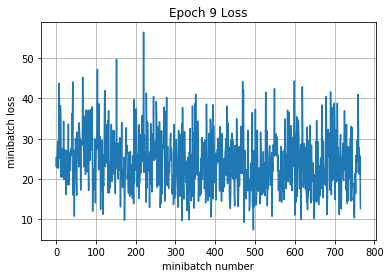

Iteration 6900: with minibatch training loss = 0.386 and accuracy of 0.86
Iteration 7000: with minibatch training loss = 0.418 and accuracy of 0.88
Iteration 7100: with minibatch training loss = 0.457 and accuracy of 0.83
Iteration 7200: with minibatch training loss = 0.249 and accuracy of 0.92
Iteration 7300: with minibatch training loss = 0.283 and accuracy of 0.91
Iteration 7400: with minibatch training loss = 0.504 and accuracy of 0.8
Iteration 7500: with minibatch training loss = 0.311 and accuracy of 0.89
Iteration 7600: with minibatch training loss = 0.409 and accuracy of 0.83
Epoch 10, Overall loss = 0.336 and accuracy of 0.882


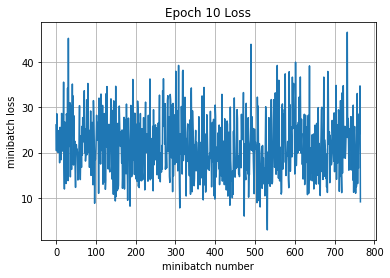

Validation
Epoch 1, Overall loss = 1.04 and accuracy of 0.716


(1.0434238247871399, 0.71599999999999997)

In [6]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [7]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.345 and accuracy of 0.881
Validation
Epoch 1, Overall loss = 1.09 and accuracy of 0.723


(1.0903146495819092, 0.72299999999999998)